In [22]:
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import l2a_runner
import os
import json

### Define Product Locations and options

In [23]:
resolution = 60

base_l2a_dir = "/scratch/toml/sentinel_2_data/reports"
report_dir = f"{base_l2a_dir}/TEST5"

base_l1c_dir = "/scratch/toml/sentinel_2_data/locations"

locs = {
    "CH": "S2A_MSIL1C_20230903T101601_N0509_R065_T32TMS_20230903T140124.SAFE",
    "BRA": "S2A_MSIL1C_20230909T141721_N0509_R010_T21MTS_20230909T192148.SAFE",
    # 'ALG' : f'{base_l1c_dir}/ALG/S2B_MSIL1C_20230904T103629_N0509_R008_T30RXT_20230904T125735.SAFE'
}
locations = {}
for loc_name, loc_path in locs.items():
    loc_product_description = loc_path.split(".")
    if loc_product_description[-1] != "SAFE":
        raise ValueError(
            f"Invalid product description: {loc_product_description}. Expected SAFE file"
        )
    (
        misssion_id,
        product_level,
        date_take,
        processing_baseline,
        orbit_number,
        tile,
        product_discriminator,
    ) = loc_product_description[0].split("_")

    locations[loc_name] = {
        "loc_name": loc_name,
        "l1c_product_name": loc_product_description[0],
        "l1c_path": f"{base_l1c_dir}/{loc_name}/{loc_path}",
        "mission_id": misssion_id,
        "date_take": date_take,
        "processing_baseline": processing_baseline,
        "orbit_number": orbit_number,
        "tile": tile,
        "product_discriminator": product_discriminator.split(".")[0],
    }

### Define modifications

In [24]:
# NO_DATA, SATURATED_OR_DEFECTIVE, CASTED_SHADOWS, CLOUD_SHADOWS, VEGETATION, NOT_VEGETATED, WATER, UNCLASSIFIED, CLOUD_MEDIUM_PROBABILITY, CLOUD_HIGH_PROBABILITY, THIN_CIRRUS, SNOW
SC_const_labels = [
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '0',
    #     'info' : 'Set whole SCL layer to NO_DATA',
    #     'name' : 'class_NO_DATA'
    # },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '1',
    #     'info' : 'Set whole SCL layer to SATURATED_OR_DEFECTIVE',
    #     'name' : 'class_SATURATED_OR_DEFECTIVE'
    # },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '2',
    #     'info' : 'Set whole SCL layer to CASTED_SHADOWS',
    #     'name' : 'class_CASTED_SHADOWS'
    # },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "3",
        "info": "Set whole SCL layer to CLOUD_SHADOWS",
        "name": "class_CLOUD_SHADOWS",
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "4",
        "info": "Set whole SCL layer to VEGETATION",
        "name": "class_VEGETATION",
    },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '5',
    #     'info' : 'Set whole SCL layer to NOT_VEGETATED',
    #     'name' : 'class_NOT_VEGETATED'
    # },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '6',
    #     'info' : 'Set whole SCL layer to WATER',
    #     'name' : 'class_WATER'
    # },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '7',
    #     'info' : 'Set whole SCL layer to UNCLASSIFIED',
    #     'name' : 'class_UNCLASSIFIED'
    # },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '8',
    #     'info' : 'Set whole SCL layer to CLOUD_MEDIUM_PROBABILITY',
    #     'name' : 'class_CLOUD_MEDIUM_PROBABILITY'
    # },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '9',
    #     'info' : 'Set whole SCL layer to CLOUD_HIGH_PROBABILITY',
    #     'name' : 'class_CLOUD_HIGH_PROBABILITY'
    # },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '10',
    #     'info' : 'Set whole SCL layer to THIN_CIRRUS',
    #     'name' : 'class_THIN_CIRRUS'
    # },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '11',
    #     'info' : 'Set whole SCL layer to SNOW',
    #     'name' : 'class_SNOW'
    # },
]

### Create modified L2A products

In [25]:
data_info = {}
data_info["reference"] = []
for loc_name, loc_dict in locations.items():
    mod_name = "reference"
    print(f"Running {loc_name}: {mod_name}")
    output_dir = f"{report_dir}/{loc_name}/{mod_name}"

    if os.path.isdir(output_dir):
            print(f"{loc_name}: {mod_name} already exists. Skipping...")
    else:
        os.makedirs(output_dir, exist_ok=True)

        runner = l2a_runner.L2A_process_runner(
            loc_dict["l1c_path"], output_dir, resolution=resolution
        )
        runner.run()

    info_dict = {
        "name": f"{loc_name}_{mod_name}",
        "loc": loc_dict,
        "mod": None,
        "output_dir": output_dir,
    }
    data_info["reference"].append(info_dict)


data_info["modified"] = []
for mod in SC_const_labels:
    for loc_name, loc_dict in locations.items():
        mod_flag = mod["flag"]
        mod_val = mod["value"]
        mod_name = mod["name"]

        print(f"Running {loc_name}: {mod_name}")
        output_dir = f"{report_dir}/{loc_name}/{mod_name}"
        if os.path.isdir(output_dir):
            print(f"{loc_name}: {mod_name} already exists. Skipping...")
        else:
            os.makedirs(output_dir, exist_ok=True)

            os.environ[mod_flag] = mod_val
            runner = l2a_runner.L2A_process_runner(
                loc_dict["l1c_path"], output_dir, resolution=resolution
            )
            runner.run()
            os.environ.pop(mod_flag, None)

        info_dict = {
            "name": f"{loc_name}_{mod_name}",
            "loc": loc_dict,
            "mod": mod,
            "output_dir": output_dir,
        }
        data_info["modified"].append(info_dict)

        print(f"Running {loc_name}: {mod_name}")


# Save data_info as json
with open(f"{report_dir}/data_info.json", "w") as f:
    json.dump(data_info, f, indent=4)

Running CH: reference
CH: reference already exists. Skipping...
Running BRA: reference
BRA: reference already exists. Skipping...
Running CH: class_CLOUD_SHADOWS
CH: class_CLOUD_SHADOWS already exists. Skipping...
Running CH: class_CLOUD_SHADOWS
Running BRA: class_CLOUD_SHADOWS
BRA: class_CLOUD_SHADOWS already exists. Skipping...
Running BRA: class_CLOUD_SHADOWS
Running CH: class_VEGETATION
CH: class_VEGETATION already exists. Skipping...
Running CH: class_VEGETATION
Running BRA: class_VEGETATION
BRA: class_VEGETATION already exists. Skipping...
Running BRA: class_VEGETATION


### Import modified L2A products

In [26]:
bands = [
    "B01",
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B8A",
    "B09",
    "B11",
    "B12",
    "AOT",
    "SCL",
    "TCI",
    "WVP",
]

reference_bands = {}
for loc_name, loc_dict in locations.items():
    reference_bands[loc_name] = {}

for data_run in data_info["reference"]:
    loc = data_run["loc"]
    loc_name = loc["loc_name"]
    for band in bands:
        band_file = f"{loc['tile']}_{loc['date_take']}_{band}_{resolution}m.jp2"
        granule_path = f"{data_run['output_dir']}/{os.listdir(data_run['output_dir'])[0]}/GRANULE"
        granule_path = f"{granule_path}/{os.listdir(granule_path)[0]}"
        reference_bands[loc_name][band] = rio.open(
            f"{granule_path}/IMG_DATA/R{resolution}m/{band_file}", driver="JP2OpenJPEG"
        )

modified_bands = {}
for loc_name, loc_dict in locations.items():
    modified_bands[loc_name] = {}
    for mod in SC_const_labels:
        mod_name = mod["name"]
        modified_bands[loc_name][mod_name] = {}
for data_run in data_info["modified"]:
    loc = data_run["loc"]
    loc_name = loc["loc_name"]
    mod_name = data_run["mod"]["name"]
    for band in bands:
        band_file = f"{loc['tile']}_{loc['date_take']}_{band}_{resolution}m.jp2"
        granule_path = f"{data_run['output_dir']}/{os.listdir(data_run['output_dir'])[0]}/GRANULE"
        granule_path = f"{granule_path}/{os.listdir(granule_path)[0]}"
        modified_bands[loc_name][mod_name][band] = rio.open(
            f"{granule_path}/IMG_DATA/R{resolution}m/{band_file}", driver="JP2OpenJPEG"
        )

### Data Analysis

In [41]:
BOA_QUANTIFICATION_VALUE = 10000
BOA_ADD_OFFSET = -1000


def true_color_image(product, product_name):
    blue = product["B02"]
    green = product["B03"]
    red = product["B04"]

    filename = f"{product_name}_TCI_{resolution}m.jp2"
    tci = rio.open(
        filename,
        "w",
        driver="JP2OpenJPEG",
        width=blue.width,
        height=blue.height,
        count=3,
        crs=blue.crs,
        transform=blue.transform,
        dtype=blue.dtypes[0],
    )
    tci.write(blue.read(1), 3)
    tci.write(green.read(1), 2)
    tci.write(red.read(1), 1)
    tci.close()


def plot_true_color_image(product):
    brightness = 4.0
    blue = product["B02"].read(1) * brightness / 65536
    green = product["B03"].read(1) * brightness / 65536
    red = product["B04"].read(1) * brightness / 65536

    rgb = np.dstack((red, green, blue))
    print(f"Max value: {np.max(rgb)}")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(
        rgb,
        interpolation="none",
    )
    ax.set_title("True Color Image")
    ax.set_axis_off()
    plt.show()

def plot_rgb_image(product, red_band,green_band,blue_band):
    brightness = 5.0
    blue = product[blue_band].read(1) * brightness / 65536
    green = product[green_band].read(1) * brightness / 65536
    red = product[red_band].read(1) * brightness / 65536

    rgb = np.dstack((red, green, blue))
    print(f"Max value: {np.max(rgb)}")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(
        rgb,
        interpolation="none",
    )
    ax.set_title(f"False colour RGB with bands {red_band}, {green_band}, {blue_band}")
    ax.set_axis_off()
    plt.show()


def plot_band(product, band, color_map="gray"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(
        product[band].read(1),
        interpolation="none",
        cmap=color_map,
    )
    ax.set_title(f"{band}")
    ax.set_axis_off()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max value: 1.13018798828125


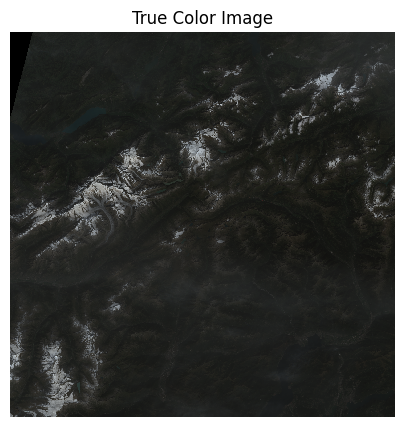

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max value: 1.4127349853515625


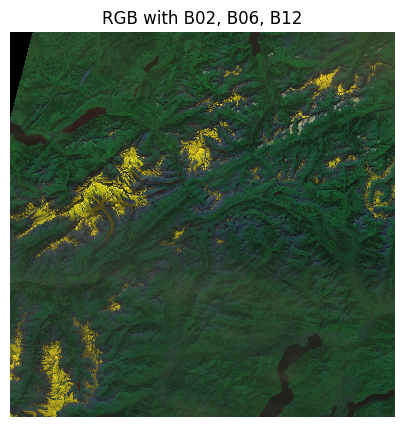

In [47]:
plot_true_color_image(reference_bands['CH'])
# plot_band(reference_bands['CH'], 'SCL', color_map='Blues')

plot_rgb_image(reference_bands['CH'], 'B02','B06','B12')

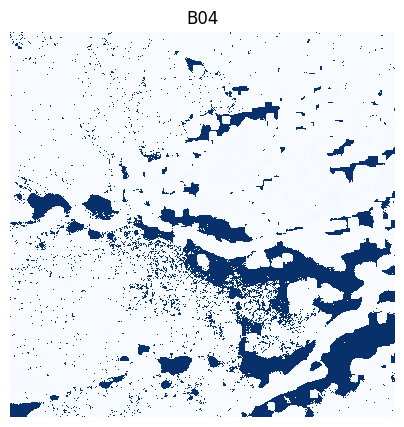

In [53]:
def band_difference_plot(product1, product2, band, color_map="Blues"):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(
        product1[band].read(1) - product2[band].read(1),
        interpolation="none",
        cmap=color_map,
    )
    ax.set_title(f"{band}")
    ax.set_axis_off()
    plt.show()

band_difference_plot(reference_bands['BRA'], modified_bands['BRA']['class_CLOUD_SHADOWS'], 'B04', color_map='Blues')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max value: 4.9999237060546875


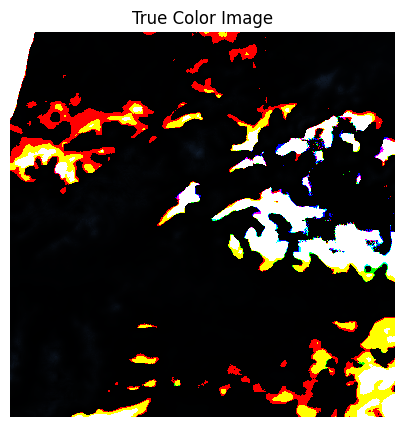

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max value: 1.13018798828125


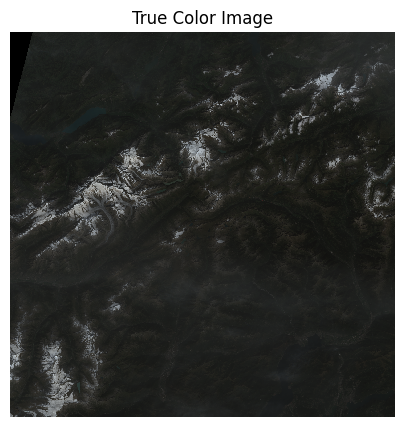

In [57]:
#plot rgb differnce between reference and modified
brightness = 5.0
loc = 'CH'
blue = reference_bands[loc]['B02'].read(1) - modified_bands[loc]['class_CLOUD_SHADOWS']['B02'].read(1)
green = reference_bands[loc]['B03'].read(1) - modified_bands[loc]['class_CLOUD_SHADOWS']['B03'].read(1)
red = reference_bands[loc]['B04'].read(1) - modified_bands[loc]['class_CLOUD_SHADOWS']['B04'].read(1)

blue = blue * brightness / 65536
green = green * brightness / 65536
red = red * brightness / 65536

rgb = np.dstack((red, green, blue))
print(f"Max value: {np.max(rgb)}")
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(
    rgb,
    interpolation="none",
)
ax.set_title("True Color Image")
ax.set_axis_off()
plt.show()

plot_true_color_image(reference_bands['CH'])
